# Introduction
This notebook demonstrates how to run simulations for all possible combinations of a set of parameter values, what I'm referring to as a "gridsearch" for lack of a better term (open to suggestions).

This involves applying the same principles as the previous example notebook, only this time we'll be using some additional tools so that we don't have to manage all the models, parameters and results ourselves.

In [1]:
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np

from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import governing_equations
from unified_model import gridsearch  # <-- The new set of tools we'll be using exist in the `gridsearch` module

# Set-up the grid of parameters
The first thing we'll need to do is set up the parameter search space.

Previously, we set each component for `UnifiedModel`, first by constructing the `MechanicalModel`, `ElectricalModel`
and `CouplingModel`, and then by combining these three "sub-models" with a set of `governing_equations` to created the final `UnifiedModel`.

This time, we follow a similar pattern, but instead create a dictionary with lists of components we want to use as our parameter search space.

Let's step through it slowly:

## One-shot components
We'll first define the components that will remain fixed across the entire gridsearch.
This process is exactly the same as in the previous example notebook.

If anything in here looks unfamiliar, see the previous example notebook.

In [10]:
# Mechanical Components

acc_input = mechanical_components.AccelerometerInput(
    raw_accelerometer_input='./data/2019-05-23_A/A/log_01_acc.csv',
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms',
    smooth=True,
    interpolate=True
)

magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='./data/magnetic-spring/10x10alt.csv',
    magnet_length=10/1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

magnet_assembly = mechanical_components.MagnetAssembly(
    n_magnet=1,
    l_m=10,
    l_mcd=0,
    dia_magnet=10,
    dia_spacer=10
)

mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,
    damping_coefficient=0.5,
    magnet_length=10/1000
)

# Electrical Components
R_coil = 12.5

load = electrical_components.SimpleLoad(R=20)

v_rect_drop = 0.1

flux_model = electrical_components.FluxModelInterp(
    c=1,  # Number of coils
    m=1,  # Number of magnets
    c_c=0.059,  # Coil center
    l_ccd=0,  # Distance between coils
    l_mcd=0,  # Distance between magnets
)
df = pd.read_csv('./data/fea-flux-curves/example_flux_curve.csv')
df.columns = ['time_ms', 'flux']  # Rename the columns to something more friendly
df['z'] = df['time_ms']*0.35/1000  # Get position of magnet by multiplying the time by the velocity (0.35m/s in this case)
df['flux'] = np.abs(df['flux'])
flux_model.fit(df['z'].values, df['flux'].values)  # Fit the flux model

## Search-space components
Next, let's define the components we want to use as our grid's "search space". 

In [11]:
# Create a range of mechanical friction dampers we want to simulate
dampers = []
for d in [0, 0.015, 0.03]:
    damper = mechanical_components.ConstantDamper(d)
    dampers.append(damper)
    
# Create a range of coupling models we want to simulate
coupling_models = []
for c in [0., 1.]:
    coupling_model = CouplingModel().set_coupling_constant(c)
    coupling_models.append(coupling_model)

## Assemble all the components together
We now need to create a list for each of our components. This will be used to define the grid's "search space".

We need to create:

- 2 dictionaries (one for the **mechanical components**, one for the **electrical components**)
  - Each `key` is the **name** of the component
  - Each `value` is a **list** of components
  
To get a list of all parameters that must be set, just print out an empty `MechanicalModel` or `ElectricalModel`!

In [47]:
print(MechanicalModel())  # ↓ all possible components are printed below

Mechanical Model: 
      magnetic_spring: None
      mechanical_spring: None
      magnet_assembly: None
      damper: None
      input_: None


In [48]:
print(ElectricalModel())  # ↓ all possible components are printed below

Electrical Model: 
      flux_model: None
      dflux_model: None
      coil_resistance: inf
      rectification_drop: None
      load_model: None


**We create our two dictionaries below:**

In [49]:
mech_components = {
    'input_excitation': [acc_input],  # Create a list with only one parameter
    'magnetic_spring': [magnetic_spring],  # Create a list with only one parameter
    'magnet_assembly': [magnet_assembly],  # Create a list with only one parameter
    'mechanical_spring': [mech_spring],  # Create a list with only one parameter
    'damper': dampers  # Our different friction dampers
}

# We only use one value for each parameter of the electrical model in this example
elec_components = {
    'coil_resistance': [R_coil],
    'rectification_drop': [v_rect_drop],
    'load_model': [load],
    'flux_model': [flux_model.flux_model],
    'dflux_model': [flux_model.dflux_model]
}

We'll also need to create:

- 2 Lists (one for the **governing equations**, and one for the **coupling model**)

In this example, we've already created our list of `CouplingModel`s, but we do still need to create our list of `governing_equations` we want to use (only one, in this case).

In [50]:
gov_equations = [governing_equations.unified_ode]

# Putting it all together

## Building the model "factory"
The `gridsearch` module provides a useful helper class that will generate `UnifiedModel`s for all possible permutations of our components. We use this `AbstractUnifiedModelFactory` (don't be afraid of the long name) to hold all of our possible parameters:

In [51]:
abstract_model_factory = gridsearch.AbstractUnifiedModelFactory(
    mech_components,
    elec_components,
    coupling_models,
    gov_equations
)

The code below is to show you how this `AbstractUnifiedModelFactory` works, but it is not intended to be used by the user this way. **This is for demonstration purposes so that you can trust that it generates a `UnifiedModel` for each parameter permutation.** If the following section is too much for now, you can safely skip over it.

Notice, when we print out our generated `UnifiedModel`s how `abstract_model_factory` creates a `UnifiedModel` for each possible permutation of all our paremeters. Pay particular attention to our non-constant parameters, the `damper`'s `damping_coefficient` and the `coupling_model`'s `coupling_constant`. They are different for each generated `UnifiedModel`:

In [55]:
for factory in abstract_model_factory.generate():
    print(factory.make())
    print('────────────────────')

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(./data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f07dc6f1d90>)
      mechanical_spring: MechanicalSpring(position=0.11, strength=1000000.0, damping_coefficient=0.5)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m=10, l_mcd=0, dia_magnet=10, dia_spacer=10)
      damper: ConstantDamper: 
      damping_coefficient: 0
      input_: <unified_model.mechanical_components.input_excitation.accelerometer.AccelerometerInput object at 0x7f07dce610b8>
  electrical_model: Electrical Model: 
      flux_model: <scipy.interpolate.interpolate.interp1d object at 0x7f07dc6bebd8>
      dflux_model: <scipy.interpolate.interpolate.interp1d object at 0x7f07dc6bef48>
      coil_resistance: 12.5
      rectification_drop: 0.1
      load_model: SimpleLoad: 20 Ohms
  coupling_model: CouplingModel(coupling_constant=0.0)
  governing_equations: <function unified_ode at 0x7f07dcb5dc80>
  raw_solution: 

## Specifying metrics, tracking parameters and curves
If we're running a grid search, you probably want to do a number of things:

1. Track which parameters are important to you
2. Calculate some metrics on the simulation results (eg. RMS of the predicted emf)
3. Calculate _scores_ or metrics that depend on some groundtruth data (eg. DTW-distance between the predicted emf and recorded emf)
4. Save certain simulation curves / waveforms for later inspection (eg. save the predicted emf for a simulation, or the predicted displacement of the magnet assembly)

We'll be going over how to accomplish each of the above cases.

### Tracking parameters
You almost always want to track certain parameters, so that we can see how the impact our metrics.

In our example, we have a list of damping coefficients for the friction damper, as well as list of coupling constants we wish to track. So we specify them as follows:

In [108]:
params_to_track = [
    'damper.damping_coefficient',
    'coupling_model.coupling_constant'
]

Virtually every object and its parameters is accessible for tracking in this way. The following syntax is used: `<component>.<parameter>`
The following components are supported:
- `damper`
- `magnet_assembly`
- `magnetic_spring`
- `mechanical_spring`
- `input_excitation`
- `coil_resistance`
- `rectification_drop`
- `load_model`
- `flux_model`
- `dflux_model`
- `coupling_model`
- `governing_equations`

To get an idea for which parameters are available, simply print out each of the components. For example, to see which parameters are available for the magnet assembly, we can print out the magnet assembly we created earlier:

In [109]:
print(magnet_assembly) # -- we see that `n_magnet`, `l_m`, `l_mcd`, `dia_magnet`, `dia_spacer` are available for tracking

MagnetAssembly(n_magnet=1, l_m=10, l_mcd=0, dia_magnet=10, dia_spacer=10)


### Calculate metrics that _don't_ depend on groundtruth
If you wish to calculate metrics that don't depend on groundtruth, for example RMS or maybe the maximum position of the magnet assembly, you declare a dictionary with the following syntax:

```python
calc_metrics = {
    '<prediction-expression>': {
        '<name-of-metric>': '<metric-function>',
        '<name-of_metric>': '<metric-function>',
        ...
    },
    '<prediction-expression>': {
        '<name-of-metric>': '<metric-function>',
        ...
    }
}
```

The `<prediction-expression>` is the same expression-style as used in the `.get_result` method we explored in the previous example notebook. `<name-of-metric>` specifies the name you wish to give your particular metric, and the `<metric-function>` is a callable function that accepts an array of values (from the `<prediction-expression>`) and outputs your metric. The syntax may look a little weird at first, but once you get the hang of it, it's really intuitive to use.

If the prediction expression part is confusing, please revisit the previous example notebook!

In our example, let's calculate the maximum and minimum position of the magnet assembly relative to the tube, as well as the RMS of the EMF:

In [71]:
def calculate_max(arr):
    return np.max(arr)

def calculate_min(arr):
    return np.min(arr)

def calculate_rms(arr):
    squared = arr**2
    squared_sum = np.sum(squared)
    rms = np.sqrt(squared_sum / len(arr))
    return rms

calc_metrics = {
    'x3-x1': {  # <-- this expression gives the relative position between the magnet assembly and tube
            'max_magnet_pos': calculate_max,  # <-- calculate max position of `x3-x1`
            'min_magnet_pos': calculate_min  # <-- calculate min position of `x3-x1`
    },
    'g(t,x5)': {  # <-- this expression gives the open-circuit EMF of the microgenerator
                'rms': calculate_rms  # <-- calculate RMS of `g(t,x5)`, which is the emf
    }
}

### Calculate metrics that depend on groundtruth
If you wish to calculate metrics that _do_ depend on groundtruth, for example the DTW-distance between the predicted curve and the groundtruth curve, you need to declare a dictionary with the following syntax:

```python
calc_metrics = {
    '<prediction-expression>': Evaluator,
    '<prediction-expression>': Evaluator,
    ...
}
```
This topic is a little in-depth to be fully expanded here, but see final section of the "Calculating Metrics" section in the previous example notebook for some hints. Otherwise, email me :)

### Saving curves
Very often you not only want the metrics, but the actual predicted curves themselves as well (usually to plot and inspect). This is easily done by specifying a dictionary with the following syntax:

```python
curve_expressions = {
    '<prediction-expression>': '<name>',
    '<prediction-expression>': '<name>',
    ...
}
```

For example:

In [72]:
curve_expressions = {
    't': 'time',  # <-- `t` is the expression for the time stamps
    'x3-x1': 'y_diff',  # <-- `x3-x1` is the expression for the relative displacement between tube and magnet assembly
    'x5': 'flux_linkage',  # <-- `x5` is the expression for the flux linkage
    'g(t,x5)': 'emf' # <-- `g(t, x5)` is the expression for the gradient, relative to time, of x5 (flux linkage)
}

# Run the grid search
With everything ready, we can run the gridsearch using the `GridsearchBatchExecutor` class.  
The `GridsearchBatchExecutor` class makes use of the `ray` distributed compute engine to execute the simulations in parallel using as many threads as your CPU supports. The class also provides you with full logging output.


We run the gridsearch as follows (of course, everything is documented with the `?` function as well):

In [101]:
grid_executor = gridsearch.GridsearchBatchExecutor(
    abstract_unified_model_factory=abstract_model_factory,
    curve_expressions=curve_expressions,
    score_metrics=None,  # <-- remember, we aren't calculating these
    calc_metrics=calc_metrics,
    parameters_to_track=params_to_track
)

# Run!
results = grid_executor.run()

2020-04-09 22:00:54,228 :: INFO :: Starting Ray...
2020-04-09 22:00:54,229	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-09 22:00:54,230	INFO resource_spec.py:212 -- Starting Ray with 5.81 GiB memory available for workers and up to 2.92 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-09 22:00:54,541	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
2020-04-09 22:00:54,744 :: INFO :: Running grid search...
2020-04-09 22:00:59,798 :: INFO :: Progress: 0/6
2020-04-09 22:01:04,799 :: INFO :: Progress: 4/6
2020-04-09 22:01:06,137 :: INFO :: Progress: 6/6
2020-04-09 22:01:06,157 :: INFO :: Gridsearch complete. Shutting down Ray...


In [102]:
# Inspect our results
results

,time,y_diff,flux_linkage,emf,param_set_id,max_magnet_pos,min_magnet_pos,rms,damper.damping_coefficient,coupling_model.coupling_constant
0,0.000000,0.040000,0.000000,0.0,0.0,0.110100,0.012734,0.375605,0.00,0.0
1,0.002950,0.040004,0.000000,0.0,0.0,0.110100,0.012734,0.375605,0.00,0.0
2,0.005950,0.040017,0.000000,0.0,0.0,0.110100,0.012734,0.375605,0.00,0.0
3,0.008950,0.040039,0.000000,0.0,0.0,0.110100,0.012734,0.375605,0.00,0.0
4,0.011950,0.040070,0.000000,0.0,0.0,0.110100,0.012734,0.375605,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
16109,7.988488,0.041885,0.151221,0.0,5.0,0.095101,0.018911,0.089771,0.03,1.0
16110,7.991488,0.041885,0.151221,0.0,5.0,0.095101,0.018911,0.089771,0.03,1.0
16111,7.994488,0.041884,0.151221,0.0,5.0,0.095101,0.018911,0.089771,0.03,1.0
16112,7.997488,0.041884,0.151221,0.0,5.0,0.095101,0.018911,0.089771,0.03,1.0


If you inspect the results of the gridsearch, you can see the various calculated metrics, tracked parameters and expressions. Each unique set of parameters gets a unique `param_set_id`, so that you can reliably track which parameters produced which result.

As a fun example, let's plot the `y_diff` for each parameter set:

In [103]:
from plotnine import *

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 934 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


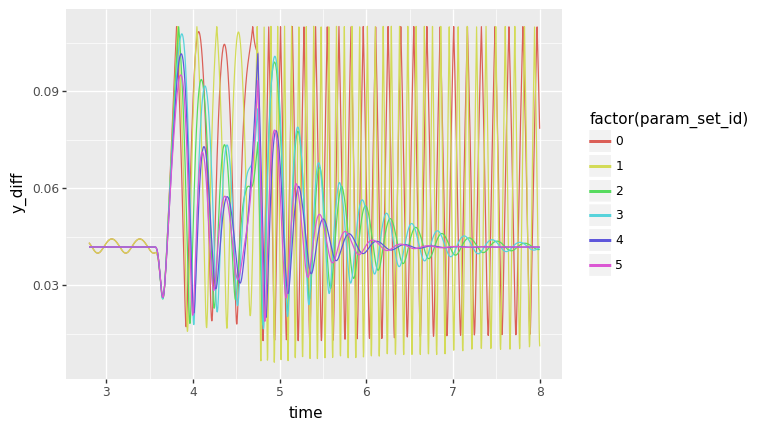

<ggplot: (-9223363307375603319)>

In [104]:
p = ggplot(aes(x='time', y='y_diff', color='factor(param_set_id)'), results)
p + geom_line() + xlim(2.8, 8)

---
Or perhaps the RMS for each value of `damping_coefficient`:

In [105]:
reduced_results = results.drop(['time', 'y_diff', 'flux_linkage', 'emf'], axis=1).drop_duplicates()
reduced_results

,param_set_id,max_magnet_pos,min_magnet_pos,rms,damper.damping_coefficient,coupling_model.coupling_constant
0,0.0,0.110100,0.012734,0.375605,0.000,0.0
2708,1.0,0.110200,0.006097,0.591393,0.000,1.0
5440,2.0,0.110023,0.017830,0.121680,0.015,0.0
8110,3.0,0.107820,0.016528,0.127516,0.015,1.0
10778,4.0,0.101824,0.020074,0.089004,0.030,0.0
13446,5.0,0.095101,0.018911,0.089771,0.030,1.0


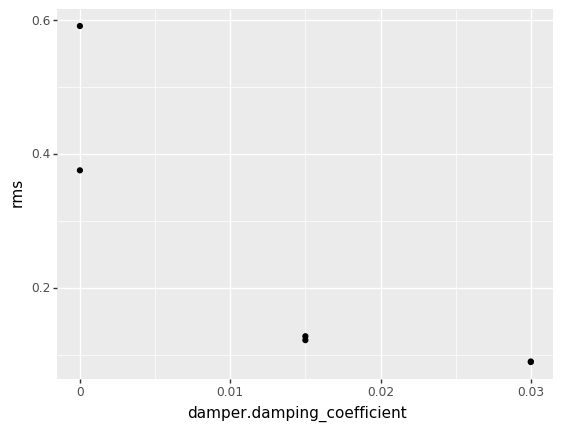

<ggplot: (8729479172570)>

In [106]:
p = ggplot(aes(x='damper.damping_coefficient', y='rms'), reduced_results)
p + geom_point()

It's quite a powerful system, once you get the hang of it.

# End
This brings us to the end. If there are any questions or additional things you need help with, feel free to get in touch with me via email or in-person.